# Evolutionary Algorithms

This is the final project of the second block of the Evolutionary Algorithms subject of the Master in Software Engineering and Artificial Intelligence.

The project consists of solving an image reconstruction problem.

## 1 - Problem

Given a black and white photograph represented as a matrix of size mxn where each position (i, j) is a value of 0-255 indicating the gray scale of the corresponding pixel. And given that they give us such a matrix but with the rows permuted in some unknown way. Our goal is to find a rearrangement of the rows so that we can reconstruct the original image. Obviously said rearrangement is represented by a permutation. Of course we do not know the original appearance of the photograph, since otherwise the problem would be trivial. We have to program an evolutionary algorithm to solve the problem.

One example of the input images are:

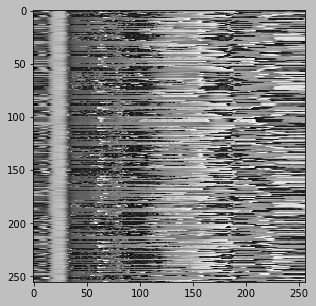

In [1]:
import time
import copy

from scipy import stats
import numpy as np
from matplotlib import pyplot as plt 
from tabulate import tabulate
import tqdm

img0 = np.loadtxt('../data/img0-shuffled.txt')
plt.style.use('grayscale')
plt.figure(figsize=(15,5))
plt.imshow(img0)

## 2 - Steady State Genetic Algorithm (ssGA)

I already implemented the ssGA algorithm for the previous project and I will use the same implementation. The specific implementation for this problem will be discussed later.

## 3 - Source Code

### 3.1 - Generic

In this section I will present my version of the ssGA. This version is adapted from the code written in Java found in the web of [neo](https://neo.lcc.uma.es/software/ssga/description.php) from the University of Malaga.

This section holds only the generic code applied to ssGA or event to every GA, the class specifications for the specific problem of the subset sum will be explained in the next section.

The first part of the code is the population. It is an abstraction to group a group of individuals. It takes as arguments the number of individuals and a function able to generate them. The population is generated at instantiation time.

This class has some additional functionalities like the possibility of iterating through it, access to random positions in its internal array, get the size of the population or print it.

In [2]:
class Population:
    def __init__(self, size, individual_generator):
        self._population = [individual_generator() for i in range(size)]
            
    def __getitem__(self, indices):
        return self._population[indices]
    
    def __setitem__(self, indices, values):
        raise NotImplemented
    
    def __iter__(self):
        self._n = 0
        return self

    def __next__(self):
        if self._n < len(self._population):
            self._n += 1
            return self._population[self._n-1]
        else:
            raise StopIteration
    
    def __str__(self):
        return '\n'.join([str(i) for i in self._population])
    
    def __repr__(self):
        return self.__str__()
    
    def __len__(self):
        return len(self._population)

Next we have the definition of a problem. This is an abstract class that will have to be specialized to a defined problem, it acts like the definitions of an interface mainly.

It says that with a problem we will be able to get the phenotype of an individual, get its fitness value and count the number of evaluations.

In [3]:
class Problem:
    def __init__(self):
        self.evaluations = 0
    
    def evaluate(self, indiv):
        self.evaluations += 1
        return self._evaluate(indiv)
        
    def _evaluate(self, indiv):
        raise NotImplemented       
        
    def phenotype(self, indiv):
        raise NotImplemented  

The same for the class EvolutionaryAlgorithm. It just define an interface that has to be implemented later on in a subclass.

In [4]:
class EvolutionaryAlgorithm:
    def __init__(self, problem, config):
        self.config = config
        self.problem = problem
        self.population = None
        self._generate_population()
        self.iterations = 0
        
    def _generate_population(self):
        raise NotImplemented
        
    def selection(self):
        raise NotImplemented
    
    def combination(self):
        raise NotImplemented
    
    def mutation(self):
        raise NotImplemented
        
    def replacement(self):
        raise NotImplemented
        
    def is_terminated(self):
        raise NotImplemented
        
    def step(self):
        self.iterations += 1
        self._step()
        
    def run(self):
        raise NotImplemented
    
    def get_solution(self):
        raise NotImplemented
        
    def _step(self):
        raise NotImplemented

The class Experiment in another interface. This one will be useful to hold different experiences to reach a conclusion. For example, it could hold different executions with different population sizes.

In [5]:
class Experiment:
    def __init__(self):
        self.config = None
        self.problem = None
        self.algorithm = None
        self.results = None
        
    def setup_execution(self):
        raise NotImplemented
    
    def teardown_execution(self):
        raise NotImplemented
    
    def execution(self):
        raise NotImplemented
    
    def run(self):
        raise NotImplemented

### 3.2 - Specific for the problem

In this section I will present the specialization of the previously explained interfaces and some other needed classes.

We are going to start choosing a representation for the individuals for this problem.

The chosen representation is an array of integers of the same length as the number of rows of the problem. This array represents permutations of the rows.

The Chromosome is just an array of integers randomly initialized and the Individual it is a class that holds a Chromosome and its fitness value.

In [6]:
class Chromosome:
    def __init__(self, length:int):
        self._alleles = np.array(range(length)).astype(np.int)
        np.random.shuffle(self._alleles)
    
    @staticmethod
    def from_values(values):
        c = Chromosome(len(values))
        c.alleles = values
        return c
    
    @property
    def alleles(self):
        return self._alleles
        
    @alleles.setter
    def alleles(self, values):
        self._alleles = np.array(list(values), dtype=np.int)
        
    def __getitem__(self, indices):
        return self.alleles[indices]
    
    def __setitem__(self, indices, values):
        self.alleles[indices] = values
    
    def __str__(self):
        return '-'.join([str(i) for i in self.alleles])
    
    def __repr__(self):
        return self.__str__()
    
    def __len__(self):
        return self.alleles.size

In [7]:
class Individual:
    def __init__(self, length:int):
        self._chromosome = Chromosome(length)
        self._fitness = 0.0
    
    @staticmethod
    def get_factory(length):
        return lambda: Individual(length)
        
    @property
    def fitness(self):
        return self._fitness
        
    @fitness.setter
    def fitness(self, value:float):
        self._fitness = value
        
    @property
    def chromosome(self):
        return self._chromosome
        
    @chromosome.setter
    def chromosome(self, chrom):
        self._chromosome.alleles = Chromosome.from_values(chrom)
        
    def __eq__(self, other):
        return (self._chromosome.alleles == other.chromosome.alleles).all()
     
    def __lt__(self, other):
        return self.fitness < other.fitness
        
    def __le__(self, other):
        return self.fitness <= other.fitness
        
    def __gt__(self, other):
        return self.fitness > other.fitness
        
    def __ge__(self, other):
        return self.fitness >= other.fitness
        
    def __str__(self):
        return f'Chromosome: {self.chromosome}\nFitness: {self.fitness}'
    
    def __repr__(self):
        return self.__str__()
    
    def __len__(self):
        return len(self.chromosome)

The specialization for the problem is defined in this class, ProblemImage. Here we define the fitness function as the square value of the difference of consecutive rows of the phenotype of an individual.

In [8]:
class ProblemImage(Problem):
    def __init__(self, image):
        self._image = image
        super().__init__()
        
    def _evaluate(self, indiv):
        return np.sum(np.square(np.diff(self.phenotype(indiv), axis=0)))      
        
    def phenotype(self, indiv):
        return self._image[indiv.chromosome.alleles]
    
    def __str__(self):
        return f'Image:\n {self._image}'
    
    def __repr__(self):
        return self.__str__()

The specialization for EvolutionaryAlgorithm is AlgoImage. Its characteristics in the different phases are:
- **Selection**: binary tournament.
- **Combination**: partial mapped crossover.
- **Mutation**: random swap of two alleles.
- **Replacement**: the worst individual is always replaced by the new one.
- **Termination**: after a maximum number of iterations or if the solution does not improve after 10.000 iterations.

The algorithm implements some extra features with specific knowledge of the problem.

- Randomly insert a "clever" individual: this individual is created by sorting one of the columns of the image by value. With that column sorted there is a big possibility that we get some chunks of the image where the neighbours are neighbours in the real solution.
- Regenerate population: we randomly regenerate part of the population if the solution does not improve enough in a number of iterations. We keep the best 20% individuals to perform elitism.
- Local search: in every step of the search we pick two random points of the individual and invert the order of the alleles in between those two points. The number of steps to perform in the search are picked from a log-normal distribution with mean 1 and std 1 as well, that means that most of the time we will perform a few steps but sometimes we will perform a deeper search.

In [9]:
class AlgoImage(EvolutionaryAlgorithm):
    def __init__(self, problem, config):
        self._best_ever = None
        super().__init__(problem, config)
        self._aux = None
        self._last_best_fitness = float('INF')
        self._last_best_fitness_termination = float('INF')
        
    def _generate_population(self):
        self.population = Population(self.config['population_size'], 
                                     Individual.get_factory(
                                         self.problem._image.shape[0]))
        for i in self.population:
            i.fitness = self.problem.evaluate(i)
        self._best_ever = copy.deepcopy(
            min(self.population, key=lambda x: x.fitness))
        
    def selection(self):
        self._aux = (self._binary_tournament(), self._binary_tournament())
        return self._aux
    
    def combination(self):
        # no crossover
        if np.random.rand() > self.config['prob_crossover']:
            self._aux = np.random.choice(self._aux)
        else:
            self._aux = self._partially_mapped_crossover(*self._aux)
        return self._aux
        
    def mutation(self):
        if np.random.rand() < self.config['prob_mutation']:
            i1 = np.random.randint(len(self._aux))
            i2 = i1
            while i1 == i2:
                i2 = np.random.randint(len(self._aux))
            self._aux.chromosome[i1], self._aux.chromosome[i2] = self._aux.chromosome[i2], self._aux.chromosome[i1]
        return self._aux
        
    def search(self):
        old_fit = self.problem.evaluate(self._aux)
        # one step search
        i1 = np.random.randint(len(self._aux))
        i2 = i1
        while i1 == i2:
            i2 = np.random.randint(len(self._aux))
        self._aux.chromosome.alleles[i1:i2] = self._aux.chromosome.alleles[i1:i2][::-1]
        self._aux.fitness = self.problem.evaluate(self._aux)
        # roll back if we dont improve
        if old_fit < self._aux.fitness:
            self._aux.chromosome.alleles[i1:i2] = self._aux.chromosome.alleles[i1:i2][::-1]
            self._aux.fitness = old_fit
        return self._aux
    
    def insert_solution(self):
        if np.random.rand() < self.config['prob_insert_solution']: 
            col = np.random.randint(self.problem._image.shape[1])
            print(f'Inserting solution sorting the column {col}')
            rep = max(self.population, key=lambda x: x.fitness)
            rep.chromosome = self.problem._image[:,col].argsort()
            rep.fitness = self.problem.evaluate(rep)
            self._aux = rep
            if rep.fitness < self._best_ever.fitness:
                self._best_ever = copy.deepcopy(rep)
            self.replacement()
        
    def replacement(self):
        rep = max(self.population, key=lambda x: x.fitness)
        rep.chromosome = self._aux.chromosome
        rep.fitness = self.problem.evaluate(rep)
        self._aux = rep
        if rep.fitness < self._best_ever.fitness:
            self._best_ever = copy.deepcopy(rep)
        return self._aux
    
    def regenerate(self):
        # save the 20% best solutions
        num_save = int(len(self.population)*0.2)
        bests = sorted(self.population)[:num_save]
        # regenerate the population randomly
        self._generate_population()
        # replace the worst 20%
        self.population._population = sorted(self.population)
        self.population._population[-num_save:] = bests
        self._best_ever = copy.deepcopy(
            min(self.population, key=lambda x: x.fitness))

    def is_terminated(self):
        if self.iterations >= self.config['max_num_iterations']:
            print(f'Terminated: Max number of iterations reached with {self.iterations}')
            return True
        elif self.iterations % 10000 == 0:
            # if it doesnt improve at least 1% regenerate
            if abs(self._last_best_fitness_termination - self._best_ever.fitness) < self._best_ever.fitness*0.01:
                print('Terminated: It didnt improve at all in the last 10.000 iterations')
                return True
            self._last_best_fitness_termination = self._best_ever.fitness
        
        return False
        
    def _step(self):
        self.selection()
        self.combination()
        self.mutation()
        for i in range(int(np.random.lognormal(1, 1))):
            self.search()
        self.replacement()
        self.insert_solution()
        if self.iterations % 1000 == 0:
            # if it doesnt improve at least 1% regenerate
            if abs(self._last_best_fitness - self._best_ever.fitness) < self._best_ever.fitness*0.01:
                print('regenerating the population')
                self.regenerate()
            self._last_best_fitness = self._best_ever.fitness
        
    def run(self):
        while not self.is_terminated():
            self.step()
        return self.get_solution()
    
    def get_solution(self):
        return self._best_ever
        
    def _binary_tournament(self):
        i1 = np.random.randint(len(self.population))
        i2 = i1
        while i1 == i2:
            i2 = np.random.randint(len(self.population))
        return min(self.population[i1], self.population[i2])
    
    def _single_point_crossover(self, p1, p2):
        point = np.random.randint(len(p1))
        result = copy.deepcopy(p1)
        # p would be a list of tuples with (number, index) sorted by index
        p = sorted([(i, np.where(p2.chromosome==i)[0].item()) for i in np.setdiff1d(p2.chromosome, p1.chromosome[:point])], key=lambda x: x[1])
        # now we insert them in order
        for index, (n, _) in enumerate(p):
            result.chromosome[point + index] = n 
        return result
    
    def _double_point_crossover(self, p1, p2):
        i1 = np.random.randint(len(p1))
        i2 = i1
        while i2 == i1:
            i2 = np.random.randint(len(p1))
        if i2 < i1:
            i1, i2 = i2, i1
        result = copy.deepcopy(p1)
        # p would be a list of tuples with (number, index) sorted by index
        p = sorted([(i, np.where(p2.chromosome==i)[0].item())
                    for i in np.setdiff1d(p2.chromosome, p1.chromosome[list(range(i1)) + list(range(i2,len(p1)))])],
                   key=lambda x: x[1])
        # now we insert them in order
        for index, (n, _) in enumerate(p):
            result.chromosome[i1 + index] = n 
        return result
    
    def _np_replace_with_dict(self, ar, dic):
        # https://stackoverflow.com/questions/47171356/replace-values-in-numpy-array-based-on-dictionary-and-avoid-overlap-between-new
        # Extract out keys and values
        k = np.array(list(dic.keys()))
        v = np.array(list(dic.values()))

        # Get argsort indices
        sidx = k.argsort()


        ks = k[sidx]
        vs = v[sidx]
        idx = np.searchsorted(ks,ar)

        idx[idx==len(vs)] = 0
        mask = ks[idx] == ar
        return np.where(mask, vs[idx], ar)

    def _partially_mapped_crossover(self, p1, p2):
        cut1 = np.random.randint(len(p1))
        cut2 = cut1
        while cut2 == cut1:
            cut2 = np.random.randint(len(p1))
        if cut2 < cut1:
            cut1, cut2 = cut2, cut1

        son = copy.deepcopy(p2)

        uniques = set(p1.chromosome[cut1:cut2]).symmetric_difference(set(p2.chromosome[cut1:cut2]))

        m1 = [i for i in p1.chromosome[cut1:cut2] if i in uniques]
        m2 = [i for i in p2.chromosome[cut1:cut2] if i in uniques]

        changes = dict(zip(m1, m2))
        if len(changes) != 0:
            son.chromosome = self._np_replace_with_dict(son.chromosome, changes)
            
        son.chromosome[cut1:cut2] = p1.chromosome[cut1:cut2]
        return son

The experiment is defined here. It holds a configuration for the problem with the specific parameters like probabilities of different events, execution parameters, etc.

It also holds the exact definition of the problem with the input image.

The other properties of the experiment are:
- Population size = 100
- Number of executions for every experience = 5
- Probability of crossover = 0.90
- Probability of mutation = 0.005
- Probability of inseting a "clever" solution = 0.001
- Max number of iterations = 300000

In [10]:
class ExpImg(Experiment):
    def __init__(self, file):
        super().__init__()
        # specific definition of the problem
        self._file = file
        img = np.loadtxt(self._file)
        # configuration of the experiment
        self.config = {
            # config for the experiment
            'number_executions': 5,
            'change_rand_seed': True,
            # config for the algo
            'algorithm': AlgoImage,
            'population_size': 100,
            'prob_crossover': 0.9,
            'prob_mutation': 0.005,
            'prob_insert_solution': 0.001,
            'max_num_iterations': 300000,
            # config of the problem
            'problem': ProblemImage,
            'problem_args': (img,)
        }
        # save things to plot later
        self.results = []
        self._results_execution = []
        self._results_step = {'best': [],
                        'worst': [],
                        'best_ever': [],
                        'average_fitness': [],
                        'iteration': [],
                        'time': []}
        self._time = None
        self._time_execution = None
        self._time_step = None
        # the seed used 
        self.random_seed = 0
        
    def setup_execution(self):
        # setup random seed
        if self.config['change_rand_seed']:
            np.random.seed(self.random_seed)
            self.random_seed += 1
        # create new problem and population
        self.problem = self.config['problem'](*self.config['problem_args'])
        self.algorithm = self.config['algorithm'](self.problem, self.config)
    
    def teardown_execution(self):
#        solution = self.problem.phenotype(self.algorithm.get_solution())
#        print('solution', solution)
#        print('sum(solution): ', sum(solution))
#        print('self.problem.evaluations: ', self.problem.evaluations)
#        print('--------------------------------------------------')
        pass
    
    def execution(self):
        # while not self.algorithm.is_terminated():
        started = time.time()
        for i in tqdm.tqdm(range(self.config['max_num_iterations'])):
            if self.algorithm.is_terminated():
                break
            self._time_step = time.time()
            self.algorithm.step()
            self._time_step = time.time() - self._time_step
            self._save_results_step()
            if i % 1000 == 0:
                print('-----------------------------------------------')
                print(f'iteration: {i}')
                print(f'time: {time.time()-started}')
                sol = self.algorithm.get_solution()
                print(f'best fitness: {sol.fitness}')
                plt.imshow(self.problem.phenotype(sol))
                plt.show()
        
    def run(self):
        self._time = time.time()
        for i in range(self.config['number_executions']):
            self.setup_execution()
            # self._time_execution = time.time()
            self.execution()
            # self._time_execution = time.time() - self._time_execution
            self.teardown_execution()
            # save the results
            self._save_results_execution(i)
                
        self._time = time.time() - self._time
        #print(f'Took {self._time} seconds.')
        # self._save_results_experiment()
            
    def get_problem(self):
        return self.config['problem'](*self.config['problem_args'])
    
    def _save_results_step(self):
        best = min(self.algorithm.population, key=lambda x: x.fitness)
        worst = max(self.algorithm.population, key=lambda x: x.fitness)
        best_ever = self.algorithm.get_solution()
        average_fitness = sum([i.fitness for i in self.algorithm.population])/len(self.algorithm.population)
        iteration = self.algorithm.iterations
        self._results_step['best'].append(copy.deepcopy(best))
        self._results_step['worst'].append(copy.deepcopy(worst))
        self._results_step['best_ever'].append(copy.deepcopy(best_ever))
        self._results_step['average_fitness'].append(average_fitness)
        self._results_step['iteration'].append(iteration)
        self._results_step['time'].append(self._time_step)
    
    def _save_results_execution(self, exe):
        # self._results_execution.append(copy.deepcopy(self._results_step))
        # save the results in a pickle file
        with open(self._file+'_'+str(exe)+'.pckl', 'wb') as f:
            pickle.dump(self._results_step, f)
        # to hold the results within the execution
        self._results_step = {'best': [],
                        'worst': [],
                        'best_ever': [],
                        'average_fitness': [],
                        'iteration': [],
                        'time': []}
    
    def _save_results_experiment(self):
        self.results.append(copy.deepcopy(self._results_execution))
        self._results_execution = []        

The results are too big to fit into memory so I am serializing them every execution and saving them into the disk.

I will run the experiment for the 3 images.

In [11]:
%%time
%%prun
import os
import pickle

files = ['../data/img0-shuffled.txt', '../data/img1-shuffled.txt']#, '../data/img2-shuffled.txt']
run_experiments = False
if run_experiments:
    for file in files:
        experiment_img = ExpImg(file)
        experiment_img.run()

 CPU times: user 1.22 ms, sys: 123 µs, total: 1.35 ms
Wall time: 1.13 ms


The experiment is fine for the images *img0-shuffled.txt* and *img1-shuffled.txt* but it is not for the *img2-shuffled.txt*. I tried to run this last experiment 2 times, taking 4-5 hours each of them, and at the end the serialized file was corrupted in both cases, so I decided to study the solutions in the first 2 images.

Now we are going to read the serialized files and extract the information we need to see and comment the results.

In [12]:
compact_results = {}
for file in files:
    print(file)
    experiment_img = ExpImg(file)
    compact_results[file] = {'problem': experiment_img.get_problem(),
                            'solutions': [],
                            'best_fitness': [],
                            'average_fitness': [],
                            'time': []}
    for i in range(experiment_img.config['number_executions']):
        with open(file+'_'+str(i)+'.pckl', 'rb') as f:
            print(f'reading the file {file+"_"+str(i)+".pckl"}')
            r = pickle.load(f)
        compact_results[file]['solutions'].append(r['best_ever'][-1])
        compact_results[file]['best_fitness'].append([i.fitness for i in r['best_ever']])
        compact_results[file]['average_fitness'].append(r['average_fitness'])
        compact_results[file]['time'].append(r['time'])

../data/img0-shuffled.txt
reading the file ../data/img0-shuffled.txt_0.pckl
reading the file ../data/img0-shuffled.txt_1.pckl
reading the file ../data/img0-shuffled.txt_2.pckl
reading the file ../data/img0-shuffled.txt_3.pckl
reading the file ../data/img0-shuffled.txt_4.pckl
../data/img1-shuffled.txt
reading the file ../data/img1-shuffled.txt_0.pckl
reading the file ../data/img1-shuffled.txt_1.pckl
reading the file ../data/img1-shuffled.txt_2.pckl
reading the file ../data/img1-shuffled.txt_3.pckl
reading the file ../data/img1-shuffled.txt_4.pckl


First we are going to plot the final solution for every execution.

../data/img0-shuffled.txt


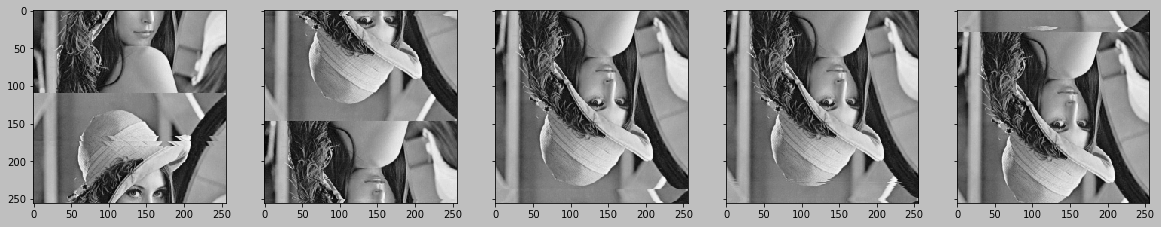

../data/img1-shuffled.txt


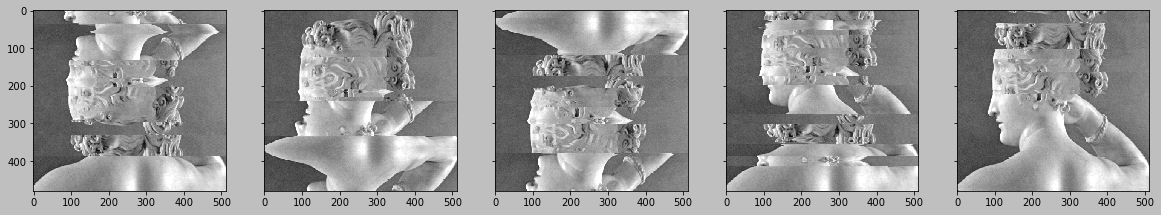

In [13]:
for k in compact_results.keys():
    print(k)
    fig, axs = plt.subplots(1, len(compact_results[k]['solutions']), figsize=(20, 5), sharex=True, sharey=True)
    for i, sol in enumerate(compact_results[k]['solutions']):
        axs[i].imshow(compact_results[k]['problem'].phenotype(sol))
    plt.show()

We can see the algorithm is effective with the first image. In this case we even get, what looks like, a couple of full solutions and the others with just a few cuts.

In the second image the solutions are not completed, we can see what would be the result but all of them have around 10 cuts in the image.


Thes see the progression of the solutions in every execution.

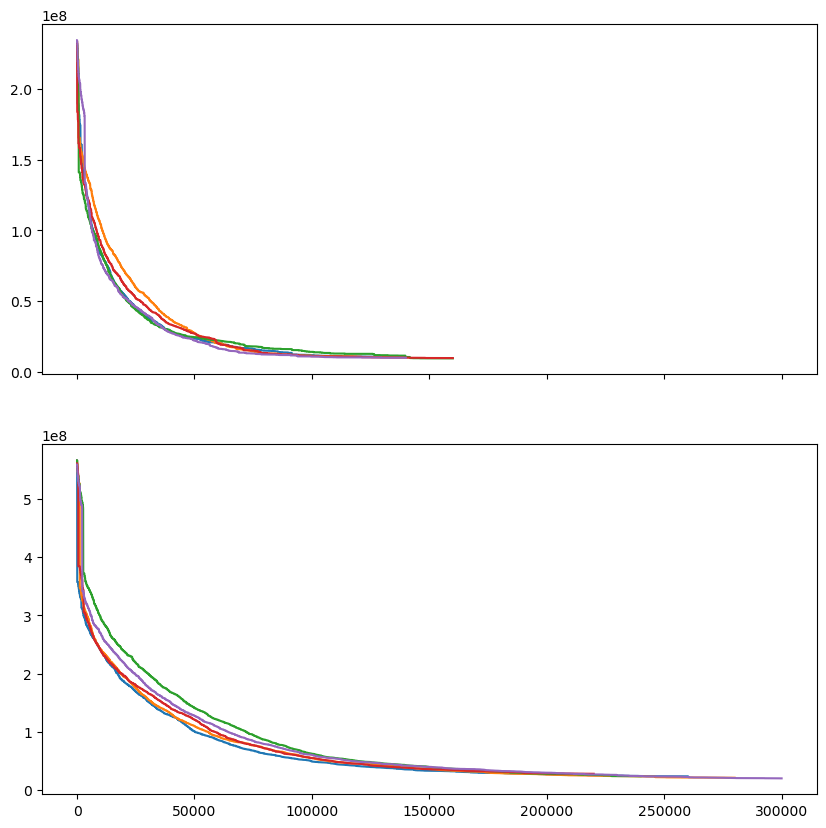

In [14]:
plt.style.use('default')
fig, axs = plt.subplots(len(compact_results), 1, figsize=(10, 10), sharex=True, sharey=False)
for i, k in enumerate(compact_results.keys()):
    for fit in compact_results[k]['best_fitness']:
        axs[i].plot(fit)
plt.show()

With the first image all the executions finished early caused by an absence of improvement in the image after 10.000 iterations. With the second image some of the executions finished early but at least one reached the maximum number of iterations.

In both cases we could leave them running for a longer time and, at some point we would get the full solution, but, as we are using a random solver, we can't be sure how long it would take.

The next we are going to have a look is the difference between the different executions, to see how consistent the algorithm is.

Image                Best fitness    Worst fitness    Average fitness       Std fitness
-----------------  --------------  ---------------  -----------------  ----------------
img0-shuffled.txt     9.37684e+06      1.06205e+07        9.95083e+06  458177
img1-shuffled.txt     2.00966e+07      2.79757e+07        2.33114e+07       2.71533e+06


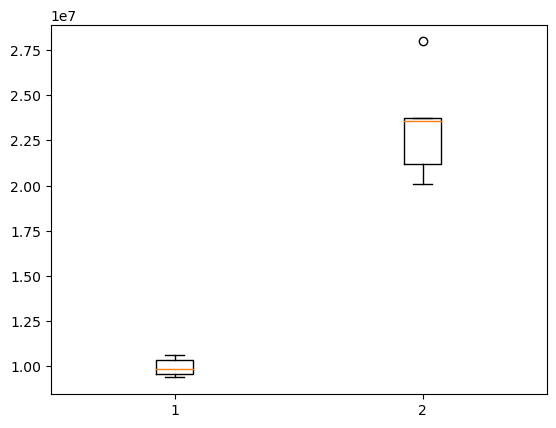

In [15]:
total = []
res_images = []
for k in compact_results.keys():
    res = [i[-1] for i in compact_results[k]['best_fitness']]
    total.append(res)
    res_images.append([k.split('/')[-1], min(res), max(res), np.average(res), np.std(res)])
print(tabulate(res_images, headers=['Image', 'Best fitness', 'Worst fitness', 'Average fitness', 'Std fitness']))

plt.boxplot(total)
plt.show()

These results suggest that with the first image the algorithm reached its best performance in all the executions but, attending the variability of the executions results, in the second image we probably need more iterations to reach a stalemate situation.


Different images have different sizes, we are going to study how this affects the time per step in the algorithm.

In [16]:
res_images = []
for k in compact_results.keys():
    res = []
    for t in compact_results[k]['time']:
        res.extend(t)
    res_images.append([k.split('/')[-1], compact_results[k]['problem']._image.shape, min(res), max(res), np.average(res), np.std(res)])
print(tabulate(res_images, headers=['Image', 'Size', 'Best time', 'Worst time', 'Average time', 'Std time']))

Image              Size          Best time    Worst time    Average time    Std time
-----------------  ----------  -----------  ------------  --------------  ----------
img0-shuffled.txt  (256, 256)  0.000831366      0.390946      0.00316481  0.00247463
img1-shuffled.txt  (480, 512)  0.00144911      10.852         0.0125706   0.0200768


The second image is, more or less, 4 times bigger than the first (x2 wide and x2 high) in the same way the average time that each step takes is also, more or less, 4 times greater in the second image. 